In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#from datetime import datetime
from country_list import countries_for_language
countries_list = dict(countries_for_language('en'))
import ast

data_folder = './data/'

### Import data set on character: 

In this project, we are going to work on the representation of the ethnicity on movies from different datas. We have approximately 450 000 characters aligned in the file `'character.metadata.tsv'` which datas are extracted from November 4 2012 , dump of freebase. It is the main data that we are going to use, as it contains the ID of the ethnicity. We are only going to keep 9 features, as we decided that we would not use other features for our analyses. We will also drop the character with non-defined ethnicity. We also remove the data after 2011 as our datas are extracted from 2012 and before 1920 as there are not enough movies.

In [2]:
data1 = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)

def format_attr(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['freebase_movie_id'] = df[df.columns[1]].astype(str)
    
     formatted_df['date'] = df[df.columns[2]]
     formatted_df['date'] = pd.to_datetime(formatted_df['date'])
     formatted_df['date'] = pd.DatetimeIndex(formatted_df['date']).year
    
     formatted_df['character_name'] = df[df.columns[3]].astype(str)
     formatted_df['gender'] = df[df.columns[5]].astype(str)
     formatted_df['ethnicity'] = df[df.columns[7]].astype(str)
     formatted_df['name'] = df[df.columns[8]].astype(str, errors='ignore')
     formatted_df['age'] = df[df.columns[9]].astype(int, errors='ignore')
     formatted_df['freebase_actor_character_id'] = df[df.columns[10]].astype(str)
     formatted_df['freebase_actor_id'] = df[df.columns[12]].astype(str)
     formatted_df['freebase_character_id'] = df[df.columns[11]].astype(str)
        
     return formatted_df

data1 =  data1[data1[data1.columns[7]].notna()]
charac_data = format_attr(data1)

#sort by datetime of movie and remove data before 1920 and after 2011
charac_data = charac_data.sort_values(by='date')
charac_data = charac_data[charac_data.date > 1919]
charac_data = charac_data[charac_data.date < 2013]
charac_data.head()

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id
367369,13050320,/m/02z4n3m,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1r4,/m/0lh0c,nan
216697,5555565,/m/0dsbmv,1920.0,nan,F,/m/03vv99,Louise Keaton,13.0,/m/040sm8h,/m/03mdkgk,nan
167280,13050489,/m/02z4n6q,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1rq,/m/0lh0c,nan
240919,31709439,/m/0bbr0cd,1920.0,Ruth Sawyer,F,/m/02ctzb,Norma Talmadge,NaN,/m/0n9mrpz,/m/042kxg,/m/0n9mrp8
267248,7036620,/m/0h1dzd,1920.0,nan,F,/m/03bkbh,Moyna MacGill,NaN,/m/02vbbqd,/m/0h1gw0,nan


For our first data set, we will only keep the following features : 

`wikipedia_id` : Wikipedia movie ID \
`freebase_movie_id` :  Freebase movie ID \
`date` :  Movie release date \
`wikipedia_id` : Character name \
`gender` : Actor gender \
`ethnicity` : Actor ethnicity (Freebase ID) \
`name` : Actor name \
`freebase_character_id` : Freebase character ID \
`freebase_actor_id` : Freebase actor ID

In [3]:
population_per_ethnicity = charac_data['ethnicity'].value_counts()
ethnicity_array = charac_data['ethnicity'].unique()

print("We keep only " + str(len(charac_data)) + " samples.")
print("We can see the occurence of each of the 477 ethnicity:")
print(population_per_ethnicity)

We keep only 101809 samples.
We can see the occurence of each of the 477 ethnicity:
/m/0dryh9k    15449
/m/0x67        9979
/m/041rx       9764
/m/02w7gg      5996
/m/033tf_      3798
              ...  
/m/01hm_          1
/m/07wsyr         1
/m/08j1fb         1
/m/026d074        1
/m/09c8kp         1
Name: ethnicity, Length: 476, dtype: int64


### Import data set on movies and merge 

We are also going to use the file `'movie.metadata'` which we are going to merge with the previous dataframe. This new dataframe will contain in addition several more features, like the countries of the movies and the revenue.

In [4]:
data2 = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
def format_attr2(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['movie_name'] = df[df.columns[2]].astype(str)    
     formatted_df['revenue'] = df[df.columns[4]].astype(int, errors='ignore')
     formatted_df['runtime'] = df[df.columns[5]].astype(int, errors='ignore')
     formatted_df['movie_languages'] = df[df.columns[6]].astype(str)
     formatted_df['movie_countries'] = df[df.columns[7]]
     formatted_df['movie_genres'] = df[df.columns[8]].astype(str)
        
     return formatted_df


movie_data = format_attr2(data2)

#keep only the characters with known id
movie_data = movie_data[movie_data['wikipedia_id'].isin(charac_data['wikipedia_id'])]
merged_data = pd.merge(charac_data, movie_data, left_on='wikipedia_id', right_on='wikipedia_id', how = 'left')
merged_data

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,13050320,/m/02z4n3m,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1r4,/m/0lh0c,nan,Pals and Pugs,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
1,5555565,/m/0dsbmv,1920.0,nan,F,/m/03vv99,Louise Keaton,13.0,/m/040sm8h,/m/03mdkgk,nan,Convict 13,NaN,25.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
2,13050489,/m/02z4n6q,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1rq,/m/0lh0c,nan,Springtime,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
3,31709439,/m/0bbr0cd,1920.0,Ruth Sawyer,F,/m/02ctzb,Norma Talmadge,NaN,/m/0n9mrpz,/m/042kxg,/m/0n9mrp8,The Branded Woman,NaN,84.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
4,7036620,/m/0h1dzd,1920.0,nan,F,/m/03bkbh,Moyna MacGill,NaN,/m/02vbbqd,/m/0h1gw0,nan,Nothing Else Matters,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01t_vv"": ""Comedy-drama""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101804,30672494,/m/0g9xjv9,2012.0,nan,M,/m/0cqgdq,Rajnikanth,61.0,/m/0gw218j,/m/02wmbg,nan,Rana,NaN,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/09s02"": ""Te...","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
101805,32985148,/m/0h533hm,2012.0,Raghu,M,/m/0dryh9k,Jiiva,27.0,/m/0h58g5n,/m/0j46lfy,/m/0h8mh95,Neethaane En Ponvasantham,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}",{},"{""/m/02l7c8"": ""Romance Film""}"
101806,23690065,/m/0gxz14q,2012.0,nan,F,/m/01rv7x,Anupama Kumar,37.0,/m/0hzw16b,/m/080kws4,nan,Mugamoodi,NaN,NaN,{},{},"{""/m/04pbhw"": ""Superhero movie""}"
101807,35997584,/m/0j_5r7f,2012.0,nan,M,/m/041rx,Eli Roth,40.0,/m/0mzm4dl,/m/058kqy,nan,Aftershock,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"


Here we get the data merged between character data and movie data.
From this data set, we want to see which country has the most diversity.

Let's try to clean the `movie_countries` feature corresponding to get a clean array.

In [5]:
def map_to_country(row, pick_one=False):
    vals = list(ast.literal_eval(row.movie_countries).values())
    pick_one = False if not vals else pick_one
    return vals if not pick_one else [vals[0]]

df_country = merged_data.copy()
df_country["movie_countries"] = df_country.apply(lambda x: map_to_country(x, False), axis =1)

df_country.sample(10)

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
22263,24158953,/m/07kblfh,1981.0,Bobby Fine,M,/m/02ctzb,Ryan O'Neal,40.0,/m/07lm764,/m/015g_7,/m/0gxnl6n,So Fine,NaN,83.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/01z4y"": ""Comedy""}"
67230,3638867,/m/09rkmj,2004.0,nan,M,/m/02w7gg,Keith Emerson,59.0,/m/0gxbp9y,/m/01pdyc2,nan,Moog,NaN,70.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/04dn71w"": ""Dance"", ""/m/017fp"": ""Biography..."
70855,10986152,/m/02qx9cr,2005.0,Young Julia,F,/m/09v5bdn,Roselyn Sanchez,31.0,/m/02vbb8q,/m/03mkhc,/m/0h16cl9,Cayo,NaN,111.0,"{""/m/06nm1"": ""Spanish Language""}",[Puerto Rico],"{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""..."
9303,2777146,/m/0822hn,1961.0,"Nandal (segment ""Postmaster"")",M,/m/0bpjh3,Anil Chatterjee,31.0,/m/0chk_zg,/m/05p4nbv,/m/0chk_zk,Teen Kanya,NaN,112.0,"{""/m/01c7y"": ""Bengali Language""}",[India],"{""/m/02n4lw"": ""Art film""}"
18936,3966196,/m/0b917c,1977.0,nan,M,/m/0g96wd,John Inman,41.0,/m/0gxgw4r,/m/0236tc,nan,Are You Being Served?,NaN,96.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"{""/m/01z4y"": ""Comedy""}"
4783,30356467,/m/0g5rx94,1949.0,nan,F,/m/0dryh9k,Banumathi,24.0,/m/0g5vypc,/m/0bcggl,nan,Laila Majnu,NaN,NaN,"{""/m/07c9s"": ""Tamil Language"", ""/m/09s02"": ""Te...",[],"{""/m/04t36"": ""Musical"", ""/m/03hn0"": ""Historica..."
63263,3159121,/m/08w677,2003.0,Lupus,M,/m/09v5bdn,Franky G,37.0,/m/03jqsfg,/m/09t4_6,/m/0bl5_q3,Confidence,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Canada, Germany]","{""/m/01jfsb"": ""Thriller"", ""/m/04btyz"": ""Heist""..."
17269,30975925,/m/0gg9_b9,1975.0,nan,F,/m/0x67,Lola Falana,NaN,/m/0mzmgs8,/m/05wcvl,nan,Lady Cocoa,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/0lsxr"": ""Crime Fiction"", ""/m/018td"": ""Bla..."
73151,12133251,/m/02vqxs0,2005.0,Tom,M,/m/0x67,Reginald VelJohnson,52.0,/m/0crt46d,/m/04n1d3,/m/0h4_kx6,Death to the Supermodels,NaN,83.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/0gf28"": ""Parody"", ""/m/03npn"": ""Horror"", ""..."
26490,23922926,/m/076y78v,1985.0,Rodney,M,/m/07mqps,Peter Fonda,45.0,/m/0g99ll4,/m/0170vn,/m/0h35x4c,Certain Fury,NaN,87.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"


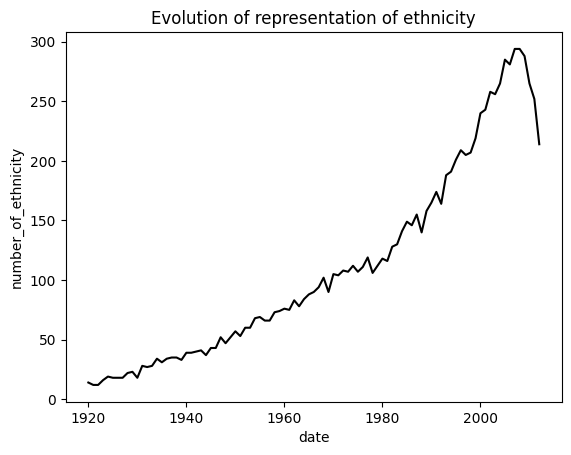

In [6]:


#plot of ethnicity representation from 1900 to 2012

date_charac = df_country.groupby(df_country['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))

plt.plot(date_charac.index, date_charac.num_of_ethnicity, color = 'black')

plt.title('Evolution of representation of ethnicity')
plt.ylabel('number_of_ethnicity')
plt.xlabel('date')
plt.show()



We want to check if this evolution is trustworthy or if it is biased by the database that we have.


(It would have been good to do some preliminary analysis whether the representation of ethnicities changes over time. You have the plot “evolution of representation of ethnicity”, but this might be influenced heavily by the database only having old american movies, but not old indian movies (or similar selection biases). You should check for what timeframe you have sufficient data to compare countries and ethnicities.)

First, there are frequently multiple countries in our dataset of movie and character data. To use it in a document categorization, we must create a new dataset that is organized by country. For each row that has two or more movie countries, we simply expand the number of rows by copying all other information and replacing the nation as a single variable.

In [7]:
# First we make a list of all the countries in the data 
countries = []
for values in df_country['movie_countries'] : 
    for value in values: 
        if value not in countries: 
            countries.append(value) 

# Convert the multiple countries in column in a multiple rows (duplication of the row for each the multiples movie_countries)
dft = df_country.explode('movie_countries')
dft= dft.reset_index()
dft.drop_duplicates(subset='freebase_movie_id', keep='first')


# Analysis movie with the revenue and the number of movies for all countries 
data_countries = pd.DataFrame()

data_countries = merged_data.groupby(dft['movie_countries']).apply(lambda x: pd.Series({
         'revenue' : np.nansum(x['revenue']),
         'number_movie': len(x['freebase_movie_id'])
    }))

# sort data with the most movie at the top
data_c =data_countries.sort_values(by='number_movie',ascending=False)
data_c.head(10)

,revenue,number_movie
movie_countries,,
United States of America,1.292356e+12,47417.0
India,4.561447e+11,18827.0
United Kingdom,2.643408e+11,9948.0
France,1.136897e+11,3819.0
Germany,1.195120e+11,3280.0
Canada,8.989223e+10,2741.0
Italy,4.308358e+10,2360.0
Japan,3.394742e+10,1162.0
Australia,3.095528e+10,932.0


In [8]:
#get dataframe with ethnicity name and the group
fname = 'mapping.pickle'
mapping = pickle.load(open(fname,'rb'))

ethn_by_nActors = charac_data['ethnicity'].value_counts()

ethn = pd.DataFrame()
ethn['ID'] = ethn_by_nActors.keys()
ethn['#Actors'] = ethn_by_nActors.values
ethn['Ethnicity'] = ethn_by_nActors.keys().map(mapping)

asian = ['/m/019kn7','/m/01xhh5','/m/03bx0k4','/m/0d2by']
southasian = ['/m/0dryh9k','/m/01rv7x','/m/02sch9','/m/04mvp8','/m/0bpjh3','/m/0cqgdq','/m/09m6hr','/m/0g0x7_','/m/023mqw','/m/0583cz']
black = ['/m/0x67']
latino = ['/m/01g7zj','/m/025rpb0','/m/09k5jvk']
mixed = []
white = ['/m/041rx','/m/02w7gg','/m/033tf_','/m/0xnvg','/m/02ctzb','/m/07hwkr','/m/07bch9','/m/03bkbh','/m/0d7wh','/m/03ts0c','/m/0222qb','/m/03lmx1','/m/065b6q','/m/01qhm_','/m/048z7l','/m/06mvq','/m/0g8_vp','/m/09vc4s','/m/013xrm','/m/06gbnc','/m/07mqps','/m/02g7sp','/m/0g96wd','/m/063k3h','/m/08hpk0','/m/042gtr','/m/09kr66','/m/03ttfc','/m/038723','/m/022dp5','/m/03vv99']
other = []
ethn_groups = {'Asian_ex_Southasian': asian, 'Southasian': southasian, 'Black/Caribbean/African': black, 'Latino': latino, 'Mixed': mixed, 'White': white, 'Other': other}

merged = pd.merge(dft, ethn, left_on='ethnicity', right_on='ID', how = 'left')
merged = merged.drop(['ID','#Actors','runtime'], axis= 1)

aaa = pd.DataFrame(ethn_groups.items(), columns = ['groups','ethnicity'])

# Convert the multiple ethnicity in column in a multiple rows (duplication of the row for each the multiples ethnicity)
ethngr = aaa.explode('ethnicity')
ethngr

#merge with previous dataset
merged = pd.merge(merged, ethngr, left_on='ethnicity', right_on='ethnicity', how = 'left')
merged

,index,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,movie_languages,movie_countries,movie_genres,Ethnicity,groups
0,0,13050320,/m/02z4n3m,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1r4,/m/0lh0c,nan,Pals and Pugs,NaN,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Scottish American,White
1,1,5555565,/m/0dsbmv,1920.0,nan,F,/m/03vv99,Louise Keaton,13.0,/m/040sm8h,/m/03mdkgk,nan,Convict 13,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",United States of America,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",British Americans,White
2,2,13050489,/m/02z4n6q,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1rq,/m/0lh0c,nan,Springtime,NaN,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Scottish American,White
3,3,31709439,/m/0bbr0cd,1920.0,Ruth Sawyer,F,/m/02ctzb,Norma Talmadge,NaN,/m/0n9mrpz,/m/042kxg,/m/0n9mrp8,The Branded Woman,NaN,{},United States of America,"{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",white people,White
4,4,7036620,/m/0h1dzd,1920.0,nan,F,/m/03bkbh,Moyna MacGill,NaN,/m/02vbbqd,/m/0h1gw0,nan,Nothing Else Matters,NaN,"{""/m/02h40lc"": ""English Language""}",United Kingdom,"{""/m/01t_vv"": ""Comedy-drama""}",Irish people,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127457,101804,30672494,/m/0g9xjv9,2012.0,nan,M,/m/0cqgdq,Rajnikanth,61.0,/m/0gw218j,/m/02wmbg,nan,Rana,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/09s02"": ""Te...",India,"{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}",Marathi people,Southasian
127458,101805,32985148,/m/0h533hm,2012.0,Raghu,M,/m/0dryh9k,Jiiva,27.0,/m/0h58g5n,/m/0j46lfy,/m/0h8mh95,Neethaane En Ponvasantham,NaN,"{""/m/07c9s"": ""Tamil Language""}",NaN,"{""/m/02l7c8"": ""Romance Film""}",Indians,Southasian
127459,101806,23690065,/m/0gxz14q,2012.0,nan,F,/m/01rv7x,Anupama Kumar,37.0,/m/0hzw16b,/m/080kws4,nan,Mugamoodi,NaN,{},NaN,"{""/m/04pbhw"": ""Superhero movie""}",Tamil,Southasian
127460,101807,35997584,/m/0j_5r7f,2012.0,nan,M,/m/041rx,Eli Roth,40.0,/m/0mzm4dl,/m/058kqy,nan,Aftershock,NaN,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}",Jewish people,White


In [9]:
df_usa = merged[merged['movie_countries'] == 'United States of America' ]
df_india = merged[merged['movie_countries'] == 'India' ]

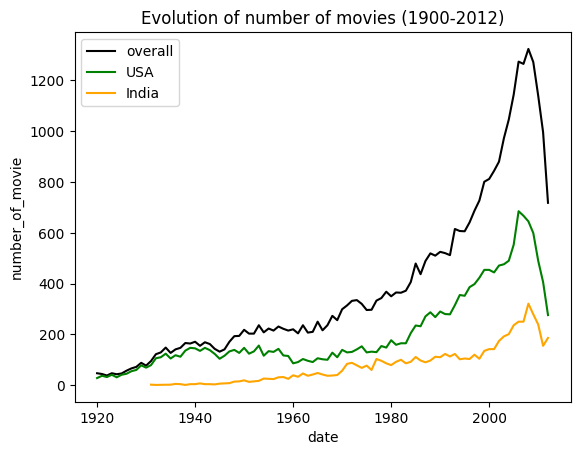

In [10]:
date_charac = merged.groupby(merged['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))

date_charac_usa = df_usa.groupby(df_usa['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))

date_charac_india = df_india.groupby(df_india['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))

plt.plot(date_charac.index, date_charac.num_of_movies, color = 'black', label = 'overall')
plt.plot(date_charac_usa.index, date_charac_usa.num_of_movies, color = 'green', label = 'USA')
plt.plot(date_charac_india.index, date_charac_india.num_of_movies, color = 'orange', label = 'India')

plt.legend(loc="upper left")
plt.title('Evolution of number of movies (1900-2012)')
plt.ylabel('number_of_movie')
plt.xlabel('date')
plt.show()


We should reduce the time for the data. Begin after 1970 ?

In [11]:
df_country_1970 = merged[merged['date'] > 1969]
charac_data_1970 = charac_data[charac_data['date'] > 1969]

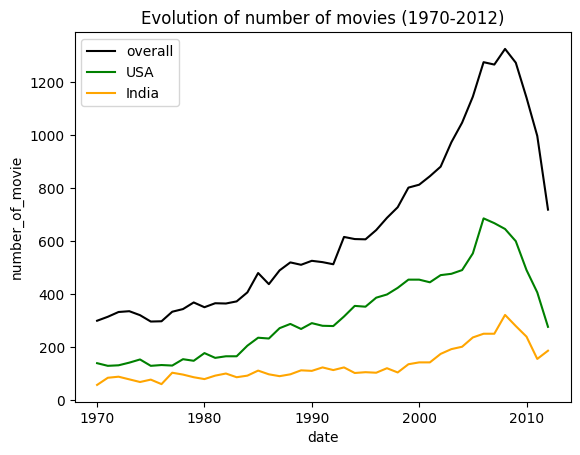

In [12]:
df_usa_1970 = df_country_1970[df_country_1970['movie_countries'] == 'United States of America' ]
df_india_1970 = df_country_1970[df_country_1970['movie_countries'] == 'India' ]

date_charac_1970 = df_country_1970.groupby(df_country_1970['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))

date_charac_usa_1970 = df_usa_1970.groupby(df_usa_1970['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))

date_charac_india_1970 = df_india_1970.groupby(df_india_1970['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))

plt.plot(date_charac_1970.index, date_charac_1970.num_of_movies, color = 'black', label = 'overall')
plt.plot(date_charac_usa_1970.index, date_charac_usa_1970.num_of_movies, color = 'green', label = 'USA')
plt.plot(date_charac_india_1970.index, date_charac_india_1970.num_of_movies, color = 'orange', label = 'India')

plt.legend(loc="upper left")
plt.title('Evolution of number of movies (1970-2012)')
plt.ylabel('number_of_movie')
plt.xlabel('date')
plt.show()


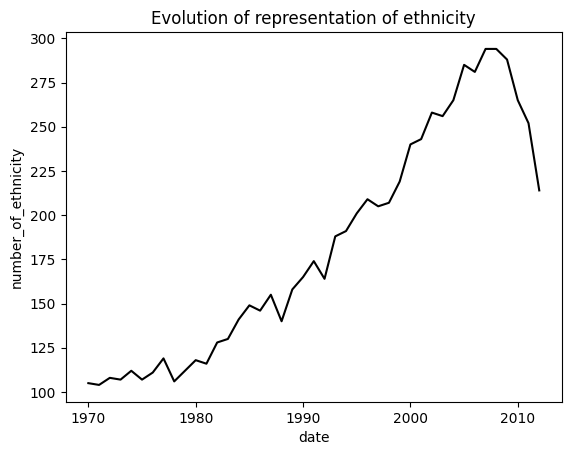

In [13]:

#plot of ethnicity representation from 1970 to 2012

date_charac_1970 = df_country_1970.groupby(df_country_1970['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))

plt.plot(date_charac_1970.index, date_charac_1970.num_of_ethnicity, color = 'black')

plt.title('Evolution of representation of ethnicity')
plt.ylabel('number_of_ethnicity')
plt.xlabel('date')
plt.show()

### How is ethnic diversity represented in each country's film industry?
Personnal cases for several region (US, China, India, Europe)

I don’t understand why you decided to limit your analysis to 9 ethnicities. In the US we might see a shift that films increasingly include black, or asian actors. But there might be similar phenomena in very different markets. China for example, does the representation of Japanese people change? Or in India, how is the distribution between the ethnicities in this country (particularly the representation of Pakistani actors might be interesting).

### China:  

In [14]:
df_china = df_country_1970[df_country_1970['movie_countries']== 'China']
df_china['movie_name'].nunique()

217

Not enought movies to conclude any result. Need to import dataset ?

### USA

In [15]:
num_movie_usa = df_usa['movie_name'].nunique()
print("We only have a sample of " + str(num_movie_usa) + " movies produced in the USA from 1970 to 2012.")

We only have a sample of 18159 movies produced in the USA from 1970 to 2012.


In [16]:
#consider only the ethnicity present more than 'x' times. We consider only movies from usa, so we can begin from 1900.
x= 50
top_ethnicity = df_usa['Ethnicity'].value_counts().index
usa_top = df_usa[df_usa['Ethnicity'].isin(top_ethnicity)]
population_per_ethnicity = usa_top['Ethnicity'].value_counts()
ethnicity_array = df_usa['Ethnicity'].unique()

ethn_usa = pd.DataFrame(population_per_ethnicity/len(usa_top))
ethn_usa.head()

,Ethnicity
African Americans,0.163656
Jewish people,0.145507
Irish Americans,0.062060
English people,0.056756
Italian Americans,0.047458


The top 5 ethnicity represent nearly fifty percent of the actors.

In [17]:
#ethnicity groups

population_per_group = df_usa['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_usa))
population_per_group

,groups
White,0.605462
Black/Caribbean/African,0.163656
Latino,0.018976
Asian_ex_Southasian,0.007835
Southasian,0.005786


Whites are clearly more represented, followed by black americans.

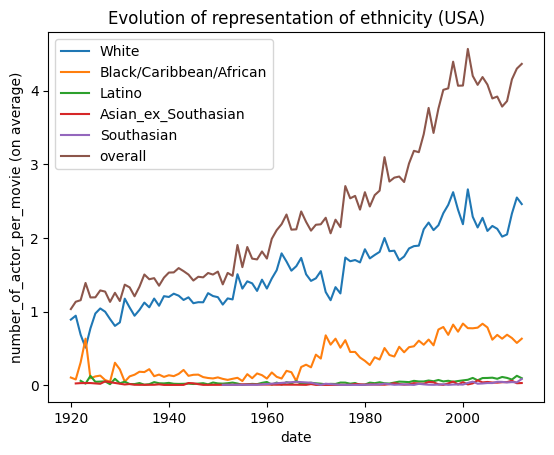

In [18]:
#number of movie per year
usa_year = df_usa.groupby(df_usa['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
usa_year['rate_overall'] = usa_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1920 to 2012 in the US
list_df = {}
for grr in population_per_group.index:
    datagrr = df_usa[df_usa['groups'] == grr]
    date_charac_usa = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_usa = pd.merge(date_charac_usa, usa_year, left_index=True, right_index=True, how = 'left')
    date_charac_usa['rate'] = date_charac_usa.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_usa

    plt.plot(date_charac_usa.index, date_charac_usa.rate, label = grr)

plt.plot(usa_year.index, usa_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (USA)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Black and white populations seem to be more and more represented in the movie industry. But the overall number of actor per movie also increase.

In [19]:
labels = np.arange(1920,2011,5).tolist()

df_white = list_df['White']
#df_white = df_white[df_white.index % 5 == 0]
df_white['pourcentage'] = df_white.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_black = list_df['Black/Caribbean/African']
#df_black = df_black[df_black.index % 5 == 0]
df_black['pourcentage'] = df_black.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_latino = list_df['Latino']
#df_latino = df_latino[df_latino.index % 5 == 0]
df_latino['pourcentage'] = df_latino.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_asian = list_df['Asian_ex_Southasian']
#df_asian = df_asian[df_asian.index % 5 == 0]
df_asian['pourcentage'] = df_asian.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_south = list_df['Southasian']
#df_south = df_south[df_south.index % 5 == 0]
df_south['pourcentage'] = df_south.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_test = pd.DataFrame(index=labels)
df_test['white'] = df_white['pourcentage']
df_test['black'] = df_black['pourcentage']
df_test['latino'] = df_latino['pourcentage']
df_test['asian'] = df_asian['pourcentage']
df_test['south'] = df_south['pourcentage']

#df_test['south'] = df_south['pourcentage']
#df_test['asian'] = df_asian['pourcentage']
#df_test['latino'] = df_latino['pourcentage']
#df_test['black'] = df_black['pourcentage']
#df_test['white'] = df_white['pourcentage']

In [20]:
df_test = df_test.fillna(0)
np_test = np.array(df_test)
df_test

,white,black,latino,asian,south
1920,0.862069,0.103448,0.000000,0.000000,0.000000
1925,0.816327,0.102041,0.040816,0.000000,0.000000
1930,0.746835,0.189873,0.025316,0.000000,0.000000
1935,0.746835,0.120253,0.006329,0.000000,0.000000
1940,0.783784,0.090090,0.022523,0.000000,0.000000
1945,0.783784,0.101351,0.013514,0.020270,0.000000
1950,0.775330,0.070485,0.017621,0.000000,0.000000
1955,0.818605,0.037209,0.004651,0.009302,0.000000
1960,0.763514,0.054054,0.027027,0.006757,0.000000
1965,0.736607,0.084821,0.013393,0.000000,0.000000


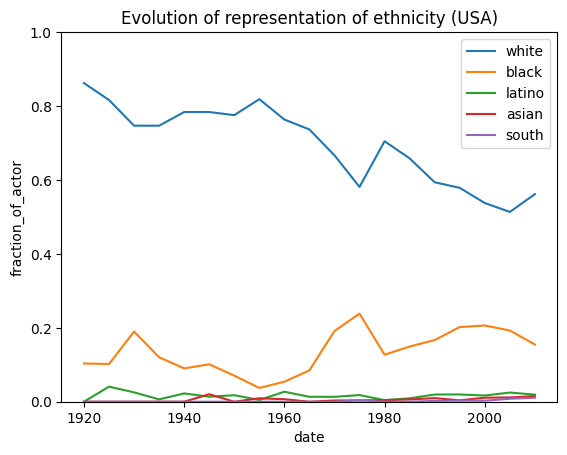

In [21]:
i=0
for grr in df_test.columns:
    plt.plot(df_test.index, df_test[grr], label = grr)
    
plt.title('Evolution of representation of ethnicity (USA)')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('fraction_of_actor')
plt.xlabel('date')
plt.show()

White actor less represented, black actor more represented but not a huge shift. Other seem to be not really represented. Why doesn't add up to 1 ? mixed people not considered. Conclusion : going in a good direction, black ethnicities more represented, mixed too. Asian not that much, considering the huge chinese diaspora. Surprising result.

### India

Good amount of movie, we have at least 5400 movies, 22 000 characters, 1200 unique actors.

In [22]:
#top_ethnicity = merged_india['Ethnicity'].value_counts().index
india_top = df_india_1970[df_india_1970['Ethnicity'].isin(top_ethnicity)]
population_per_ethnicity = df_india_1970['Ethnicity'].value_counts()
ethnicity_array = df_india_1970['Ethnicity'].unique()

ethn_india = pd.DataFrame(population_per_ethnicity/len(india_top))
ethn_india

,Ethnicity
Indians,0.655839
Tamil,0.048825
Punjabis,0.045374
Malayali,0.044866
Marathi people,0.038167
...,...
Italian Australian,0.000051
European Americans,0.000051
Native Hawaiians,0.000051
British Asian,0.000051


First of all, let's look at the presence of pakistanis in the movie industry.

In [23]:
ethn_india[ethn_india.index.isin(['Pakistani','Muslim','Pakistani American'])]

,Ethnicity
Muslim,0.001320
Pakistani American,0.000355


Not really represented. Not surprising considering the relation between the two countries.

Same analysis as for US :

In [24]:
#ethnicity groups

population_per_group = df_india_1970['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_india_1970))
population_per_group

,groups
Southasian,0.828583
White,0.007058
Black/Caribbean/African,0.000989
Latino,0.000090


Nearly only southasian. Clear difference.

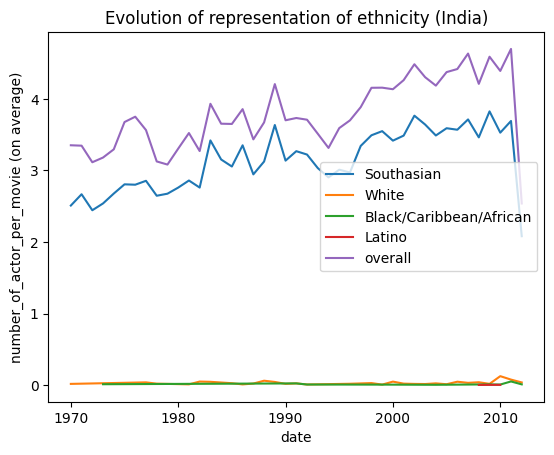

In [25]:
#number of movie per year
india_year = df_india_1970.groupby(df_india_1970['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
india_year['rate_overall'] = india_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1970 to 2012 in India
list_df = {}
for grr in population_per_group.index:
    datagrr = df_india_1970[df_india_1970['groups'] == grr]
    date_charac_india = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_india = pd.merge(date_charac_india, india_year, left_index=True, right_index=True, how = 'left')
    date_charac_india['rate'] = date_charac_india.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_india

    plt.plot(date_charac_india.index, date_charac_india.rate, label = grr)

plt.plot(india_year.index, india_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (India)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Clear that only Southasian population interest us in the case of India.

In [26]:
df_india_south = df_india_1970[df_india_1970['groups']== 'Southasian']
index_south = df_india_south['Ethnicity'].unique()
index_south

array(['Indians', 'Gujarati people', 'Punjabis', 'Kayastha',
       'Kashmiri Pandit', 'Tamil', 'Marathi people', 'Bengali people',
       'Malayali', 'Telugu people'], dtype=object)

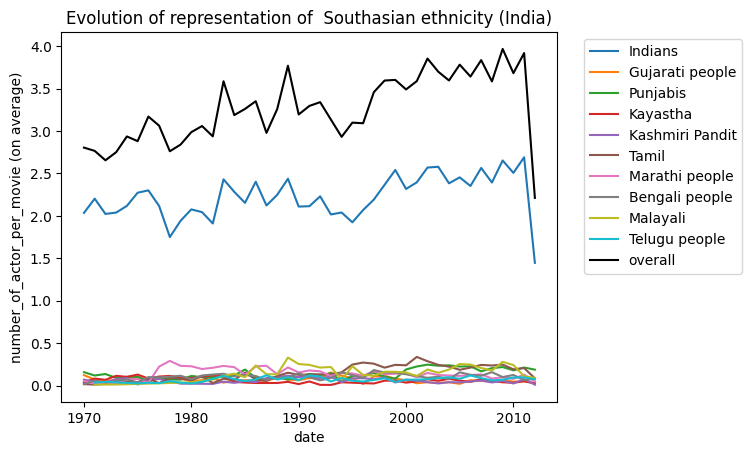

In [27]:
india_year_south = df_india_south.groupby(df_india_south['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
india_year_south['rate_overall'] = india_year_south.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)
for grr in index_south:
    datagrr = df_india_1970[df_india_1970['Ethnicity'] == grr]
    date_charac_india_south = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_india_south = pd.merge(date_charac_india_south, india_year, left_index=True, right_index=True, how = 'left')
    date_charac_india_south['rate'] = date_charac_india_south.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)

    plt.plot(date_charac_india_south.index, date_charac_india_south.rate, label = grr)

plt.plot(india_year_south.index, india_year_south.rate_overall , color = 'black' ,label = 'overall')
plt.title('Evolution of representation of  Southasian ethnicity (India)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Nothing to say apart that the few ethnicities are represented, mainly indian people are.

### Europe

In [37]:
europe = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

df_uk = df_country_1970[df_country_1970['movie_countries'] == 'United Kingdom']
df_europe_without_uk = df_country_1970[df_country_1970['movie_countries'].isin(europe)]
df_europe = pd.concat([df_uk,df_europe_without_uk], axis = 0)
len(df_europe)

25238

In [38]:
df_europe['groups'].value_counts()

White                      18236
Black/Caribbean/African     1020
Southasian                   332
Latino                       179
Asian_ex_Southasian          179
Name: groups, dtype: int64

In [44]:
#ethnicity groups

population_per_group = df_europe['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_europe))
population_per_group

,groups
White,0.722561
Black/Caribbean/African,0.040415
Southasian,0.013155
Latino,0.007092
Asian_ex_Southasian,0.007092


In [48]:
europe_top = df_europe[df_europe['Ethnicity'].isin(top_ethnicity)]
population_per_ethnicity = df_europe['Ethnicity'].value_counts()
ethnicity_array = df_europe['Ethnicity'].unique()

ethn_europe = pd.DataFrame(population_per_ethnicity/len(europe_top))
ethn_europe.head(20)

,Ethnicity
English people,0.203929
Jewish people,0.063509
French,0.058618
British people,0.045335
African Americans,0.040563
Irish people,0.035433
False,0.033842
Scottish people,0.033723
Italians,0.032928
Swedes,0.029309


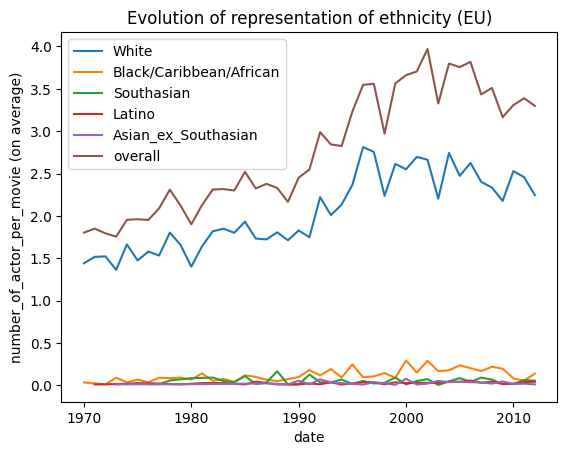

In [49]:
#number of movie per year
europe_year = df_europe.groupby(df_europe['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
europe_year['rate_overall'] = europe_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1970 to 2012 in EU
list_df = {}
for grr in population_per_group.index:
    datagrr = df_europe[df_europe['groups'] == grr]
    date_charac_europe = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : x['freebase_actor_character_id'].nunique()
        }))
    
    date_charac_europe = pd.merge(date_charac_europe, europe_year, left_index=True, right_index=True, how = 'left')
    date_charac_europe['rate'] = date_charac_europe.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_europe

    plt.plot(date_charac_europe.index, date_charac_europe.rate, label = grr)

plt.plot(europe_year.index, europe_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (EU)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()


Taking europe as a whole, we can observe a very strong representation of white people. Perhaps better to look at each country indivudually and look at ethnicity and not groups.

In [40]:
df_europe['movie_countries'].value_counts()

United Kingdom    10546
France             4337
Germany            3958
Italy              1815
Spain              1024
Ireland             627
Sweden              605
Netherlands         422
Denmark             387
Belgium             292
Hungary             229
Austria             172
Luxembourg          161
Romania             130
Poland               99
Portugal             99
Finland              95
Greece               80
Bulgaria             43
Croatia              34
Slovakia             30
Lithuania            20
Slovenia             14
Malta                13
Cyprus                6
Name: movie_countries, dtype: int64

Look more closely to UK, France, Germany.

#### UK

In [52]:
df_uk['Ethnicity'].value_counts().head(10)

English people       3228
British people        769
Jewish people         667
Scottish people       551
Irish people          441
African Americans     361
False                 304
White British         255
Welsh people          254
white people          241
Name: Ethnicity, dtype: int64

Not really diverse

#### France

In [57]:
df_france = df_europe[df_europe['movie_countries'] == 'France']
df_france['Ethnicity'].value_counts().head(10)

French               867
English people       511
Jewish people        284
Italians             200
False                171
African Americans    163
Italian Americans    110
British people       104
Germans               99
white people          95
Name: Ethnicity, dtype: int64

Much better representation. Mainly ethnicities of neighbour countries.

#### Germany

In [58]:
df_germany = df_europe[df_europe['movie_countries'] == 'Germany']
df_germany['Ethnicity'].value_counts().head(10)

English people       533
African Americans    350
Jewish people        323
Germans              236
False                172
Irish Americans      159
Italian Americans    118
white people         107
French               104
British people       104
Name: Ethnicity, dtype: int64

Surprinsingly a lot of African americans. Not a lot of german. A lot of ethnicities represented, once again neighbouring countries but also african representation.

### Top 100 movies US

In [98]:
movie_100 = df_country_1970[df_country_1970['revenue'].notna()]
movie_100 = movie_100.sort_values(by= 'revenue', ascending=False)
top_100_movie = movie_100.movie_name.unique()[0:100,]   # get name of top 100
movie_100 = df_country_1970[df_country_1970['movie_name'].isin(top_100_movie)]
movie_100

,index,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,movie_languages,movie_countries,movie_genres,Ethnicity,groups
20129,18107,518615,/m/02ktj7,1976.0,Dwan,F,/m/07hwkr,Jessica Lange,27.0,/m/0j_h7s,/m/0hsn_,/m/05lxyht,King Kong,90614445.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/0g092b"": ""Monster movie"", ""/m/0jdm8"": ""Re...",white Americans,White
20130,18108,518615,/m/02ktj7,1976.0,King Kong,M,/m/0g8_vp,Peter Cullen,35.0,/m/0h34xh0,/m/03dn9v,/m/04lr_4,King Kong,90614445.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/0g092b"": ""Monster movie"", ""/m/0jdm8"": ""Re...",Canadian Americans,White
20314,18263,518615,/m/02ktj7,1976.0,nan,M,/m/041rx,Charles Grodin,41.0,/m/0j_h7m,/m/01gy5k,nan,King Kong,90614445.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/0g092b"": ""Monster movie"", ""/m/0jdm8"": ""Re...",Jewish people,White
21184,19025,52549,/m/0dtfn,1977.0,Darth Vader,M,/m/0x67,James Earl Jones,46.0,/m/02nv74t,/m/0f6_x,/m/0f2y0,Star Wars Episode IV: A New Hope,775398007.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",African Americans,Black/Caribbean/African
21207,19046,52549,/m/0dtfn,1977.0,Leia Organa,F,/m/041rx,Carrie Fisher,20.0,/m/0k3r24,/m/01tnbn,/m/0ddqw,Star Wars Episode IV: A New Hope,775398007.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",Jewish people,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127401,101763,31186339,/m/0gkz15s,2012.0,Gale Hawthorne,M,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/04yd0fh,/m/0ds96_p,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Australians,NaN
127402,101764,31186339,/m/0gkz15s,2012.0,Caesar Flickerman,M,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/02bj6k,/m/0gwc3bn,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Italian Americans,White
127403,101765,31186339,/m/0gkz15s,2012.0,President Snow,M,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0ywqc,/m/0dsbx11,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Scottish American,White
127404,101766,31186339,/m/0gkz15s,2012.0,Cinna,M,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0161sp,/m/0gwc39n,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Jewish people,White


In [102]:
only_movie = movie_100.drop_duplicates(subset='movie_name', keep='first')
only_movie['movie_countries'].value_counts()

United States of America    98
Singapore                    1
Name: movie_countries, dtype: int64

In [99]:
movie_100['Ethnicity'].value_counts()

English people                         373
Jewish people                          137
African Americans                      125
British people                         100
Scottish people                         54
                                      ... 
White Africans of European ancestry      1
Danish Canadians                         1
British Nigerian                         1
Belgians                                 1
Indo Caribbeans                          1
Name: Ethnicity, Length: 126, dtype: int64

In [101]:
movie_100['groups'].value_counts()

White                      1117
Black/Caribbean/African     125
Latino                       18
Southasian                   15
Asian_ex_Southasian          13
Name: groups, dtype: int64

Biased ? only americans movie. Say top 100 of americans movie then. As before, huge representation of white. Lot of ethnicities but not greatly represented. Black seem a bit more represented than other group ethnicities, white excluded.